In [27]:
import numpy as np
import pandas as pd
from matplotlib.pylab import plt
import statsmodels.api as sm
from PSpline import *

In [28]:
p_spline = PSpline()

## B-splines in perspective

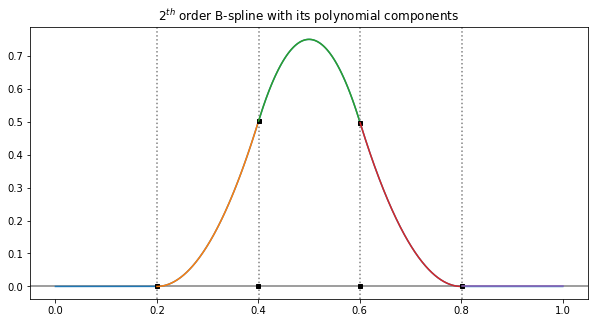

In [29]:
ndx = 5
deg1 = 2
ng = 1000
xmin, xmax = 0, 1
xg = np.linspace(xmin, xmax, ng)
Bg = p_spline.b_base(xg, xmin, xmax, n_seg=ndx, b_deg=deg1)

sample_base = Bg[:, 3]

plt.figure(figsize=(10, 5))
plt.axhline(y=0, color='gray')
plt.plot(xg, sample_base)

polynomial_component_x = np.split(xg, ndx)
polynomial_component_y = np.split(sample_base, ndx)
for i in range(1, ndx):
    plt.axvline(x=polynomial_component_x[i][0], color='gray', ls=':')
    plt.plot(polynomial_component_x[i][0], polynomial_component_y[i][0], marker="s", c="black", markersize=4)
    plt.plot(polynomial_component_x[i], polynomial_component_y[i])

plt.plot(.4, 0, marker="s", markersize=4, c="black")
plt.plot(.6, 0, marker="s", markersize=4, c="black")

plt.title('$2^{th}$ order B-spline with its polynomial components')
plt.savefig('../images/2th order B-spline with its polynomial components.png')
plt.show()

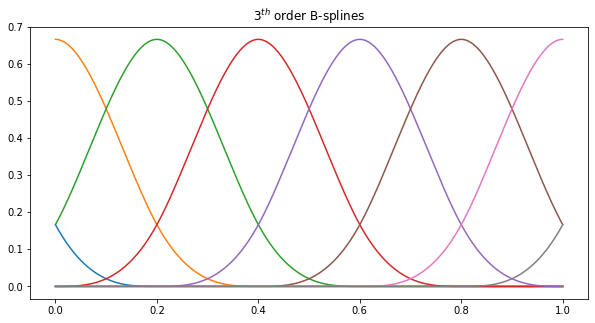

In [30]:
ndx = 5
deg1 = 3
ng = 1000
xmin, xmax = 0, 1
xg = np.linspace(xmin, xmax, ng)
Bg = p_spline.b_base(xg, xmin, xmax, n_seg=ndx, b_deg=deg1)

sample_base = Bg[:, :]

plt.figure(figsize=(10, 5))
plt.plot(xg, sample_base)

plt.title('$3^{th}$ order B-splines')
plt.savefig('../images/3th order B-splines.png')
plt.show()

## Show the essence of P-splines

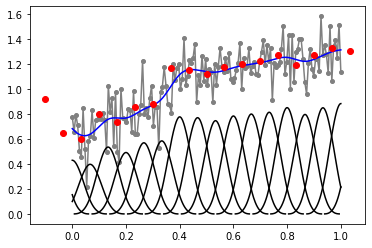

In [31]:
# Simulate data
n = 150
rng = np.random.default_rng(2016)
x = np.linspace(0, 1, num=n)
y = 0.3 + np.sin(1.2 * x + 0.3) + np.random.normal(size=n) * 0.15
Data = pd.DataFrame({'x': x, 'y': y, 'id': 15})

# Make a matrix containing the B-spline basis
ndx = 15
deg = 3
B = p_spline.b_base(x, 0, 1, n_seg=ndx, b_deg=deg)
nb = B.shape[1]

# A basis for plotting the fit on the grid xg
ng = 500
xg = np.linspace(0, 1, num=ng)
Bg = p_spline.b_base(xg, 0, 1, n_seg=ndx, b_deg=deg)

# Positions of the peaks of the B-splines
dk = 1 / ndx
xa = np.arange(ndx + deg) * dk - deg * dk / 2

# Estimate the coefficients and compute the fit on the grid
D = np.diff(np.eye(nb), n=2).T
alpha = 0.1
a = np.linalg.solve(B.T @ B + alpha * D.T @ D, B.T @ y)
z = Bg @ a

# Make a natrix with B-splines scaled by coefficients
Bsc = Bg @ np.diag(a)

# Create data frames for plot
Zf = pd.DataFrame({'x': xg, 'y': z, 'id':1})
C = pd.DataFrame({'x': xa, 'y': a, 'id': 1})
Bf = pd.DataFrame({'x': np.tile(xg, nb), 'y': Bsc.T.flatten(), 'id': np.repeat(np.arange(nb), ng)})

Bf['y'] = Bf['y'].apply(lambda y : pd.NA if y < 1e-04 else y)
Bf = Bf[Bf['y'].notna()]

# Build the graph
plt.plot(Data.x, Data.y, marker='o', c='grey', markersize=4, zorder=1)
plt.plot(Zf.x, Zf.y, c='b', zorder=2)
plt.scatter(C.x, C.y, zorder=3, c='red')
for i in range(len(Bf)):
    Bf_i = Bf[Bf.id == i]
    plt.plot(Bf_i.x, Bf_i.y, c='black', zorder=4)
plt.show()

## B-spline fits having differing support (Motorcycle data)

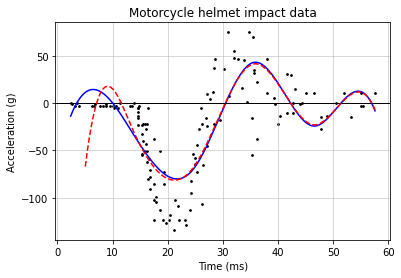

In [32]:
# Get the data
mcycle = sm.datasets.get_rdataset('mcycle','MASS').data
x = mcycle.times
y = mcycle.accel
Data = pd.DataFrame({'x': x, 'y': y})

# Boundary for the subdomain
thr = 5
sel = x > thr
xsel = x[sel]
ysel = y[sel]

# Compute the B-spline basis
deg = 3
xlo = min(x)
xhi = max(x)
ndx = 5
B = p_spline.b_base(x, xlo, xhi, n_seg=ndx, b_deg=deg)

# Basis for fit on grid
ng = 1000
xg = np.linspace(min(x), max(x), num=ng)
Bg = p_spline.b_base(xg, xlo, xhi, n_seg=ndx, b_deg=deg)

# Use 0/1 weight to select the subdomain
W = 1 * np.diag(x > thr)

# Estimate the coefficients and compute fit on the grid
a = np.linalg.solve(B.T @ B, B.T @ y)
z1 = Bg @ a
asel = np.linalg.solve(B.T @ W @ B, B.T @ W @ y)
zsel = Bg @ asel

# Create data frames for plot
Zf1 = pd.DataFrame({'x': xg, 'y': z1, 'id': 1})
Zf2 = pd.DataFrame({'x': xg[xg > thr ], 'y': zsel[xg > thr], 'id': 1})

plt.axhline(y=0, color='black', linewidth=1)
plt.scatter(Data.x, Data.y, s=3, c='black')
plt.plot(Zf1.x, Zf1.y, c='blue')
plt.plot(Zf2.x, Zf2.y, '--', c='red')
plt.title('Motorcycle helmet impact data')
plt.xlabel("Time (ms)")
plt.ylabel("Acceleration (g)")
plt.grid(linewidth=0.5)
plt.show()


## Poisson smoothing with P-splines (Coal mining data)

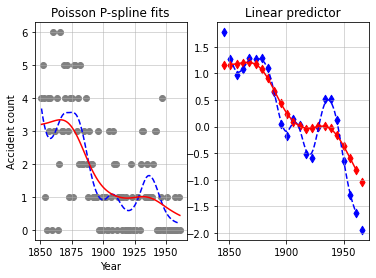

In [33]:
# Extract the data
coal = sm.datasets.get_rdataset('coal','boot').data
Count, _ = np.histogram(coal.date, bins=np.arange(1851, 1963))
Year = np.arange(1851, 1962)
xl = min(Year)
xr = max(Year)

# Poisson smoothing
n_seg = 20
b_deg = 3
fit1 = p_spline.ps_poisson(Year, Count, xl, xr, n_seg, b_deg, p_ord=2, alpha=1, show=False)
fit2 = p_spline.ps_poisson(Year, Count, xl, xr, n_seg, b_deg, p_ord=2, alpha=100, show=False)
n = len(fit1['pcoef'])
knots = (np.arange(n) -1) / n_seg
knots = xl + knots * (xr - xl)

# Plotting on fine grid
F1 = pd.DataFrame({'Year':  Year, 'Count': Count})
F2 = pd.DataFrame({
    'xg1': fit1['x_grid'],
    'xg2': fit2['x_grid'],
    'yg1': fit1['mu_grid'],
    'yg2': fit2['mu_grid'],
    'eta1': fit1['y_grid'],
    'eta2': fit2['y_grid']
})
F3 = pd.DataFrame({'knots': knots, 'pcoef1': fit1['pcoef'], 'pcoef2': fit2['pcoef']})

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(F1.Year, F1.Count, c='gray')
ax1.plot(F2.xg1, F2.yg1, '--', c='blue')
ax1.plot(F2.xg2, F2.yg2, c='red')
ax1.set_title('Poisson P-spline fits')
ax1.set_xlabel("Year")
ax1.set_ylabel("Accident count")
ax1.grid(linewidth=0.5)

ax2.scatter(F3.knots, F3.pcoef1, color='blue', marker='d')
ax2.scatter(F3.knots, F3.pcoef2, color='red', marker='d')
ax2.plot(F2.xg1, F2.eta1, '--', c='blue')
ax2.plot(F2.xg2, F2.eta2, c='red')
ax2.set_title('Linear predictor')

ax2.grid(linewidth=0.5)


## Influence of the smoothing parameter on the P-spline smoother

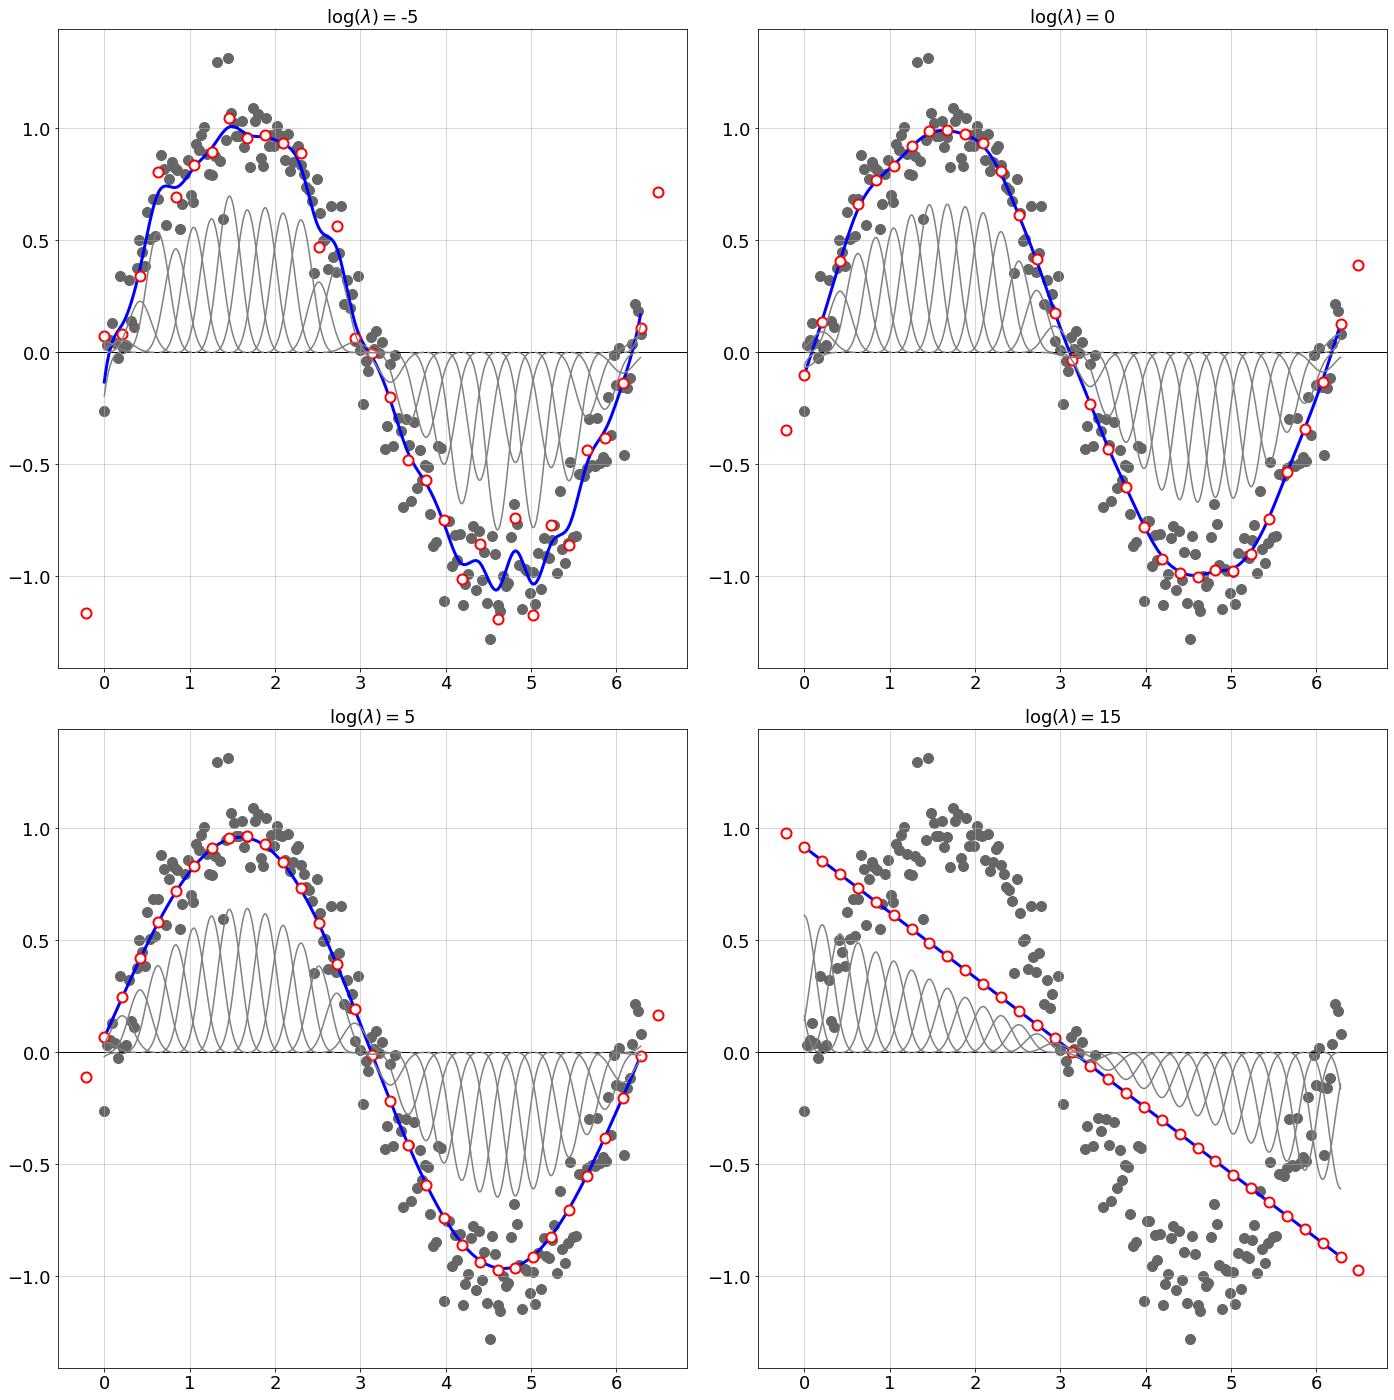

In [36]:
# Simulate data
n = 200
x_min, x_max = 0, 2 * np.pi
rng = np.random.default_rng(2022)
x = np.linspace(x_min, x_max, num=n)
y = np.sin(x) + np.random.normal(0, 1, size=n) * 0.15
Data = pd.DataFrame({'x': x, 'y': y, 'id': 15})

# Make a matrix containing the B-spline basis
ndx = 30
deg = 3
B = p_spline.b_base(x, x_min, x_max, n_seg=ndx, b_deg=deg)
nb = B.shape[1]

# A basis for plotting the fit on the grid xg
ng = 500
xg = np.linspace(x_min, x_max, num=ng)
Bg = p_spline.b_base(xg, min(x), max(x), n_seg=ndx, b_deg=deg)

# Positions of the peaks of the B-splines
dk = 1 / ndx
#xa = np.arange(ndx + deg) * dk - deg * dk / 2
xa = (np.arange(Bg.shape[1]) - 1) / ndx
xa = x_min + xa * (x_max - x_min)

def pspline_fit(nb, B, alpha):
    D = np.diff(np.eye(nb), n=2).T
    a = np.linalg.solve(B.T @ B + alpha * D.T @ D, B.T @ y)
    z = Bg @ a
    return z, a

fig_row, fig_col = 2, 2
fig, axs = plt.subplots(fig_row, fig_col, figsize=(20, 20))
fig.tight_layout(pad=4.0)
r, c = -1, 0

# Estimate the coefficients and compute the fit on the grid
alphas = np.exp([-5, 0, 5, 15])
for i, alpha in enumerate(alphas):
    z, a = pspline_fit(nb, B, alpha)

    # Make a natrix with B-splines scaled by coefficients
    Bsc = Bg @ np.diag(a)

    # Create data frames for plot
    Zf = pd.DataFrame({'x': xg, 'y': z, 'id':1})
    C = pd.DataFrame({'x': xa, 'y': a, 'id': 1})
    Bf = pd.DataFrame({'x': np.tile(xg, nb), 'y': Bsc.T.flatten(), 'id': np.repeat(np.arange(nb), ng)})

    Bf['y'] = Bf['y'].apply(lambda y : pd.NA if abs(y) < 1e-04 else y)
    Bf = Bf[Bf['y'].notna()]

    # Build the graph   
    if i % fig_col == 0:
        r += 1
        c = 0
    else: 
        c += 1
    axs[r, c].scatter(Data.x, Data.y, facecolors='#666666', s=100, zorder=1)
    axs[r, c].plot(Zf.x, Zf.y, c='b', zorder=2, linewidth=3)
    axs[r, c].scatter(C.x, C.y, marker='o', facecolors='w', edgecolors='r',linewidth=2, s=100, zorder=3)
    axs[r, c].set_title(f"$\log(\lambda) = ${int(np.log(alpha))}", fontsize=18)
    axs[r, c].tick_params(axis='both', labelsize=18)
    axs[r, c].grid(linewidth=0.5)
    for j in range(len(Bf)):
        Bf_j = Bf.loc[Bf.id == j]
        axs[r, c].plot(Bf_j.x, Bf_j.y, c='gray', zorder=3)


    axs[r, c].axhline(y=0, color='black', linewidth=1)
    

plt.savefig('../images/influence of smoothing.png')
plt.show()